# Descrição do projeto

Dataset hospedado no Kaggle:
https://www.kaggle.com/sid321axn/heart-statlog-cleveland-hungary-final

## Objetivo

Mediante a análise das características fornecidas, apresentar um modelo de machine learnig capaz de classificar com eficiência os pacientes em função do risco de ataque cardíaco.

## Atributos:

* **age** : Idade do paciente
* **sex** : Gênero do paciente
* **chest pain type** : Tipo de dor no peito \
 0: angina típica \
 1: angina atípica \
 2: outro \
 3: assintomático 
* **resting bp s** : Pressão arterial sistólica em descanso (in mm Hg)
* **cholesterol** : Colesterol em mg/dl
* **fasting blood sugar**: Diabetes (glicemia > 120 mg/dl)\
 1: sim\
 0: não
* **resting ecg** : Electrocardiograma em descanso \
 0: normal \
 1: anormal \
 2: hipertrofia vascular
* **max heart rate**: Frequência máxima cardíaca
* **exercise angina**: Angina induzida por exercício\
 1: sim\
 0: não
* **oldpeack**: *Exercise induced ST-depression in comparison with the state of rest*
* **ST slope**: declínio em teste cardiopulmonar  \
 0: Upsloping\
 1: Flat\
 2: Downsloping
* **target** : Risco de ataque cardíaco\
 0: baixo\
 1: alto

# Lendo os dados

## Importando as bibliotecas

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, \
cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve, recall_score, classification_report
from sklearn.impute import KNNImputer


## Carregando o dataset

In [ ]:
# importando o dataset via dropbox
url = 'https://www.dropbox.com/s/29b6vymoc7nlrer/heart_statlog_cleveland_hungary_final.csv?dl=1'
u = urllib.request.urlopen(url)
data = u.read()
u.close()

with open('heart.csv', "wb") as f :
   f.write(data)

# Análise preliminar

## Compreendendo o dataset

In [ ]:
df = pd.read_csv('heart.csv', sep=',')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [ ]:
linhas, colunas = df.shape
print("O dataset possui {} linhas e {} colunas.".format(linhas, colunas))
print("A coluna 'target' apresenta a variável dependente, enquanto as demais \
constituem as potenciais variáveis independentes.")

O dataset possui 1190 linhas e 12 colunas.
A coluna 'target' apresenta a variável dependente, enquanto as demais constituem as potenciais variáveis independentes.


In [ ]:
# colunas do dataset
df.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

In [ ]:
# quantitade de valores nulos e tipo de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


# Limpeza e Análise Exploratória dos Dados

## Remoção de linhas duplicadas

In [ ]:
# elementos duplicados no dataset
df[df.duplicated()]

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
163,49,0,2,110,208,0,0,160,0,0.0,1,0
604,58,1,3,150,219,0,1,118,1,0.0,2,1
887,63,1,1,145,233,1,2,150,0,2.3,3,0
888,67,1,4,160,286,0,2,108,1,1.5,2,1
889,67,1,4,120,229,0,2,129,1,2.6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,42,1,3,130,180,0,0,150,0,0.0,1,0
1157,61,1,4,140,207,0,2,138,1,1.9,1,1
1158,66,1,4,160,228,0,2,138,0,2.3,1,0
1159,46,1,4,140,311,0,0,120,1,1.8,2,1


In [ ]:
# remoção dos elementos duplicados
df.drop_duplicates(keep='first', inplace=True)

# consulta final de elementos duplicados
df[df.duplicated()]

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target


## Estatísticas descritas

In [ ]:
df.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,1.636166,0.553377
std,9.432617,0.407701,0.931031,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.609341,0.497414
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [ ]:
# quantidade de valores distintos em cada variável
df.nunique()

age                     50
sex                      2
chest pain type          4
resting bp s            67
cholesterol            222
fasting blood sugar      2
resting ecg              3
max heart rate         119
exercise angina          2
oldpeak                 53
ST slope                 4
target                   2
dtype: int64

Utilização do **pairplot** para compreender a distribuição dos dados em variáveis numéricas contínuas

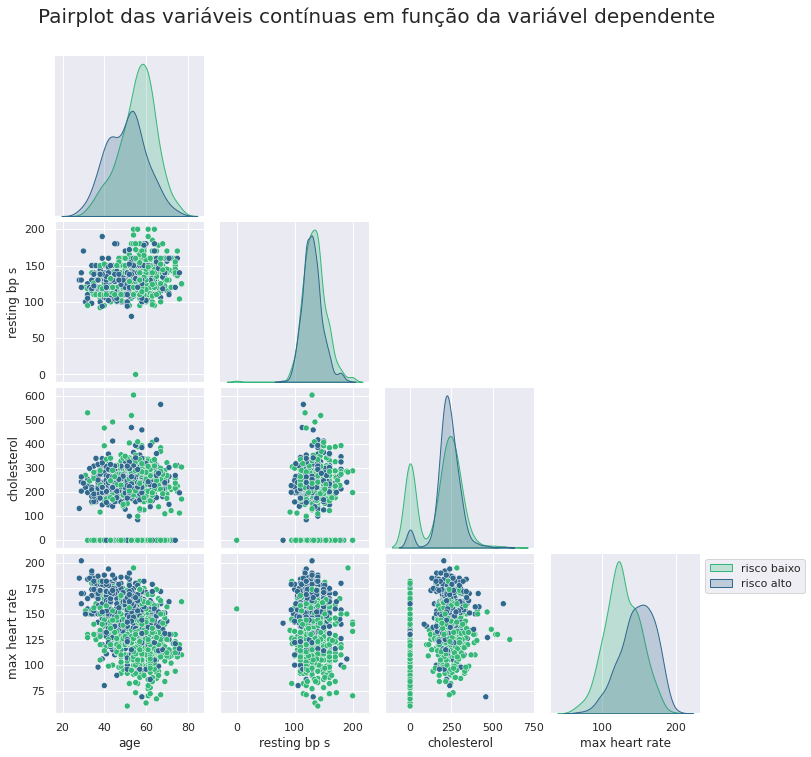

In [ ]:
#definindo as variáveis numéricas
variaveis_numericas = df[['age', 
                       'resting bp s', 
                       'cholesterol', 
                       'max heart rate', 
                       'target']]

# escolhendo o tema dos gráficos
sns.set_theme(style="darkgrid")

# criando o pairplot
ax = sns.pairplot(data=variaveis_numericas,
                  hue='target', 
                  corner=True,
                  palette='viridis')
ax._legend.remove()
ax.fig.suptitle(
    "Pairplot das variáveis contínuas em função da variável dependente", 
    fontsize=20, y = 1.05)
plt.legend(labels=["risco baixo","risco alto"], 
           loc = 2, 
           bbox_to_anchor = (1,1))
ax;

### O pairplot revelou que:
* as colunas 'resting bp s' e 'cholesterol' possuem elementos de valor zero, fato estranho devido o caráter das colunas;
* a classificação da variável dependente pode estar associada à combinação de
valores de algumas variáveis (por exemplo, cholesterol e max heart rate);
* a coluna 'oldpeak' apresenta valores negativos e positivos.

In [ ]:
# explorando os valores iguais a zero nas colunas 'cholesterol' e 'resting bp s'
print("Valores igual a zero em 'cholesterol' = ", 
      len(df[(df['cholesterol'] == 0)]))

print("Valores igual a zero em 'resting bp s' = ", 
      len(df[(df['resting bp s'] == 0)]))

Valores igual a zero em 'cholesterol' =  172
Valores igual a zero em 'resting bp s' =  1


## Limpeza de outliers

Limpeza de outliers de valor zero em 'resting bp s'

In [ ]:
# eliminando o elemento que possui 'resting bp s' igual a zero
df.drop(df[(df['resting bp s'] == 0)].index,inplace=True)

Limpeza de outliers de valor zero em 'cholesterol'

In [ ]:
# transformando valores zero em 'cholesterol' em NaN
df['cholesterol'][df['cholesterol'] == 0] = None

# treinando o knnimputer com os dados do df
knn = KNNImputer()
knn.fit(df)

# guardando os nomes de colunas em uma variável
columns = df.columns

# transformando o df com knnimputer
df = pd.DataFrame(knn.transform(df))

# retornando os nomes antes da transformação
df.columns = columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# nova verificação de valores nulos
df.isna().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [ ]:
# verificando as estatísticas descritivas após a limpeza
df.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,0.789531,3.251908,132.540894,244.920829,0.233370,0.604144,136.789531,0.404580,0.886696,1.635769,0.552890
std,9.437636,0.407864,0.931502,17.999749,54.677569,0.423206,0.806161,25.467129,0.491078,1.066960,0.609555,0.497466
min,28.000000,0.000000,1.000000,80.000000,85.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,212.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,239.200000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,273.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [ ]:
# verificação da distribuição de valores na variável dependente
df.target.value_counts()

1.0    507
0.0    410
Name: target, dtype: int64

A distribuição dos casos de classificação na variável dependente está equilibrada. Portanto, não será necessária qualquer transformação dos dados nesse sentido.

## Análise gráfica

Repetição do pairplot com a variável 'cholesterol' transformada

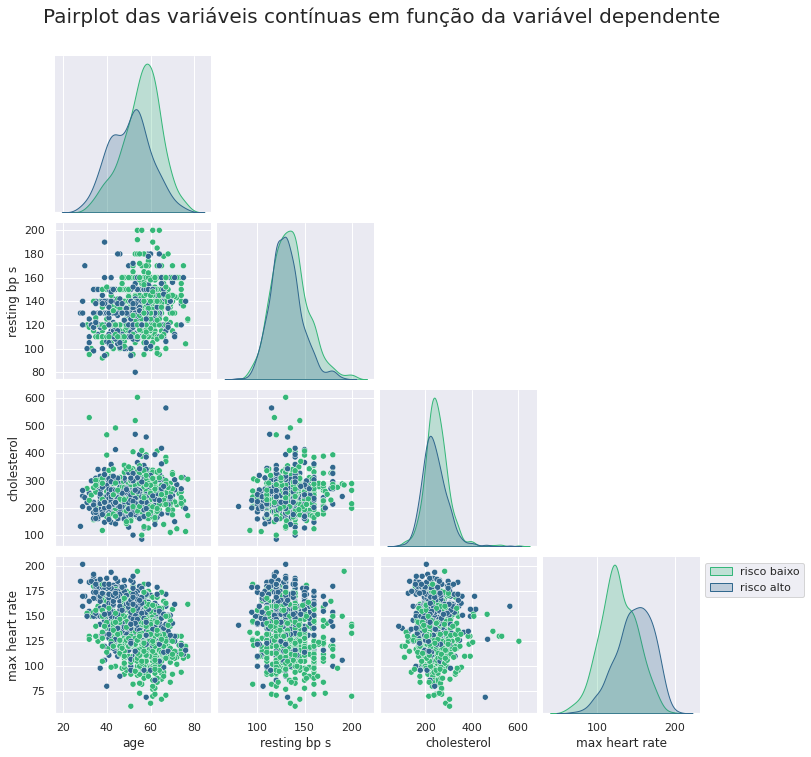

In [ ]:
#definindo as variáveis numéricas
variaveis_numericas = df[['age', 
                       'resting bp s', 
                       'cholesterol', 
                       'max heart rate', 
                       'target']]

# escolhendo o tema dos gráficos
sns.set_theme(style="darkgrid")

# criando o pairplot
ax = sns.pairplot(data=variaveis_numericas,
                  hue='target', 
                  corner=True,
                  palette='viridis')
ax._legend.remove()
ax.fig.suptitle(
    "Pairplot das variáveis contínuas em função da variável dependente", 
    fontsize=20, y = 1.05)
plt.legend(labels=["risco baixo","risco alto"], 
           loc = 2, 
           bbox_to_anchor = (1,1))
ax;

### Boxplot das variáveis contínuas
1.   age
2.   resting bp s
3.   cholesterol
4.   max heart rate
5.   oldpeak

In [ ]:
# criando função para boxplot
def boxplotvariavel(variavel, titulo, label_x):
  ax = sns.boxplot(data = variavel, 
                   orient = 'h', 
                   width = 0.5, 
                   palette="viridis")
  ax.figure.set_size_inches(12,6)
  ax.set_title(titulo, fontsize=20)
  ax.set_xlabel(label_x, fontsize=16)
  ax

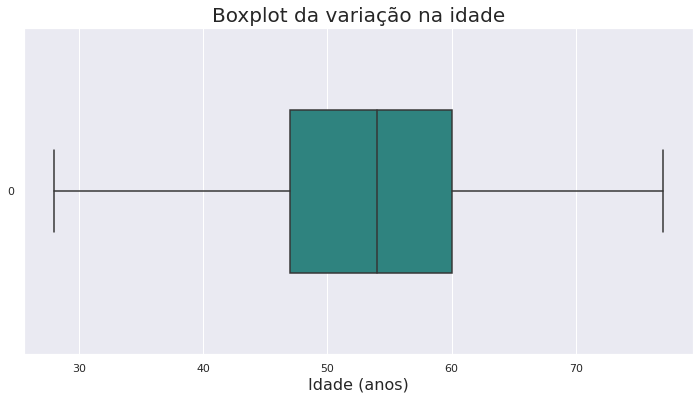

In [ ]:
# Boxplot: Idade (age)
boxplotvariavel(df['age'], 
                'Boxplot da variação na idade',
                'Idade (anos)')

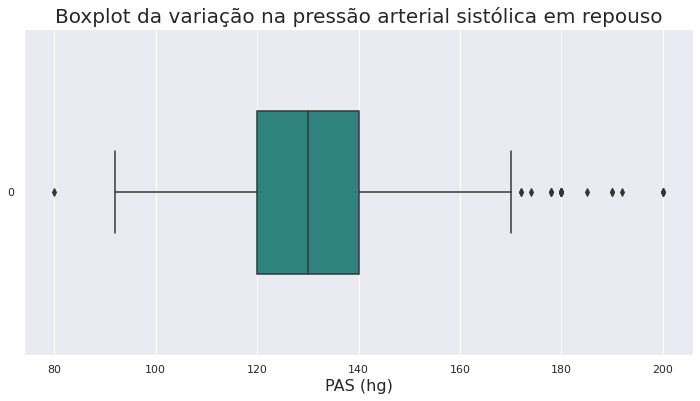

In [ ]:
# Boxplot: Pressão arterial sistólica em repouso (resting bp s)
boxplotvariavel(df['resting bp s'], 
                'Boxplot da variação na pressão arterial sistólica em repouso',
                'PAS (hg)')

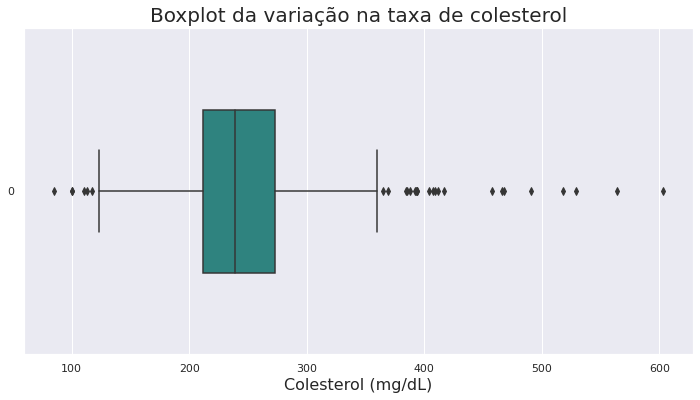

In [ ]:
# Boxplot: Colesterol (cholesterol)
boxplotvariavel(df['cholesterol'], 
                'Boxplot da variação na taxa de colesterol',
                'Colesterol (mg/dL)')

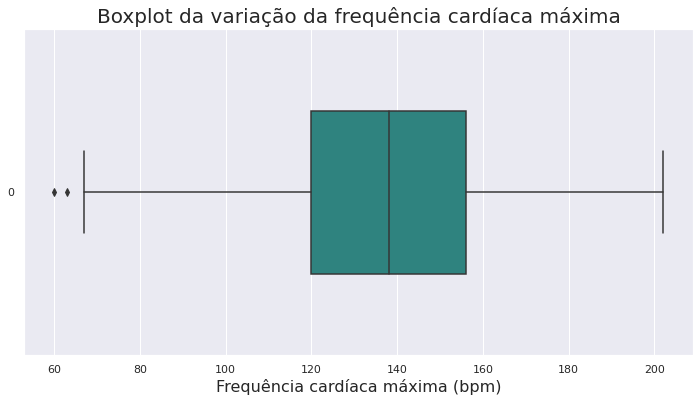

In [ ]:
# Boxplot: Frequência cardíaca máxima (max heart rate)
boxplotvariavel(df['max heart rate'], 
                'Boxplot da variação da frequência cardíaca máxima',
                'Frequência cardíaca máxima (bpm)')

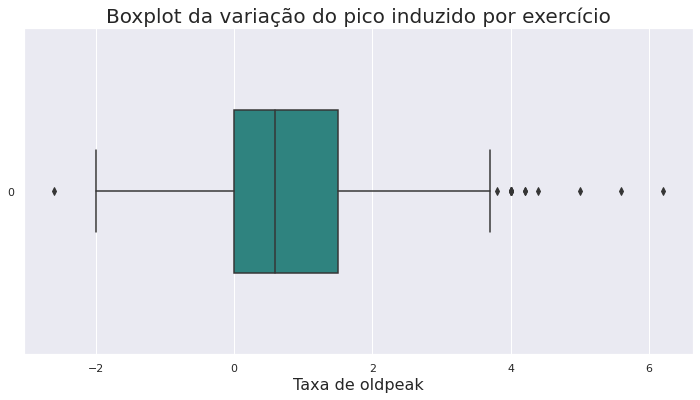

In [ ]:
# Boxplot: Pico induzido por exercício em relação ao repouso (oldpeak)
boxplotvariavel(df['oldpeak'], 
                'Boxplot da variação do pico induzido por exercício',
                'Taxa de oldpeak')

Conclusões:
As variáveis 'resting bp s', 'cholesterol', 'max heart rate' e 'oldpeak' possuem outliers.

### Representação gráfica das variáveis categóricas
1.   sex
2.   chest pain type
3.   fasting blood sugar
4.   resting ecg
5.   exercise angina
6.   ST slope 
7.   target


In [ ]:
def catplot_categoricos(x, data, titulo, x_label, ticks):
  ax = sns.catplot(x=x, 
                   kind="count", 
                   palette="viridis", 
                   data=df, 
                   hue="target", 
                   legend=False)
  ax.fig.suptitle(titulo, 
                  fontsize=20, 
                  y = 1.05)
  ax.set_xlabels(x_label, 
                 fontsize=14)
  ax.set_ylabels("Quantidade", 
                 fontsize=14)
  ax.set_xticklabels(labels=ticks)
  plt.legend(labels=["risco baixo","risco alto"],
             loc = 2, 
             bbox_to_anchor = (1,1))
  ax

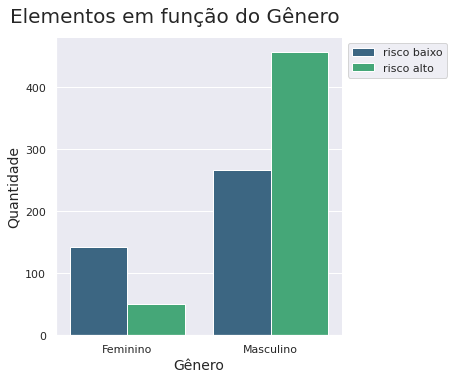

In [ ]:
# Catplot: Gênero (sex)
catplot_categoricos("sex", 
                    df, 
                    "Elementos em função do Gênero",
                    "Gênero", 
                    ("Feminino", "Masculino"))

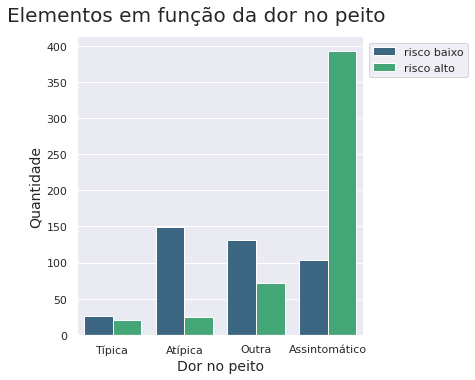

In [ ]:
# Catplot: Dor no peito (chest pain type)
catplot_categoricos("chest pain type", 
                    df,
                    "Elementos em função da dor no peito", 
                    "Dor no peito",
                    ("Típica", "Atípica", "Outra", "Assintomático"))

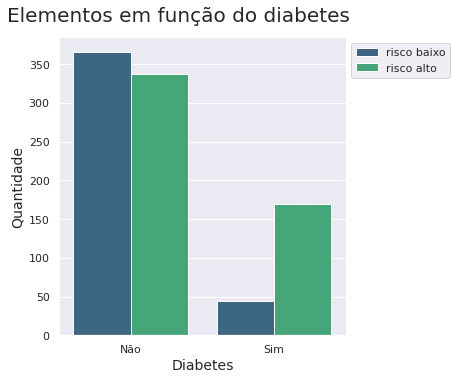

In [ ]:
# Catplot: Diabete (fasting blood sugar)
catplot_categoricos("fasting blood sugar", 
                    df,
                    "Elementos em função do diabetes", 
                    "Diabetes", 
                    ("Não", "Sim"))

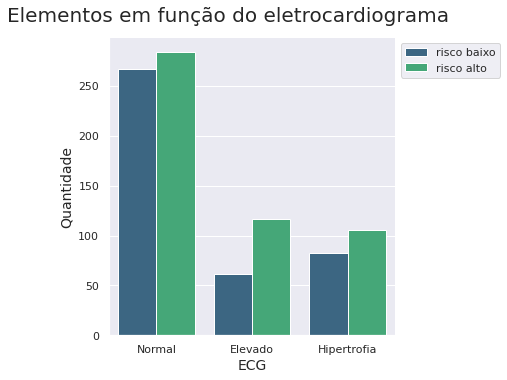

In [ ]:
# Catplot: Eletrocardiograma (resting ecg)
catplot_categoricos("resting ecg", 
                    df,
                    "Elementos em função do eletrocardiograma", 
                    "ECG", 
                    ("Normal", "Elevado", "Hipertrofia"))

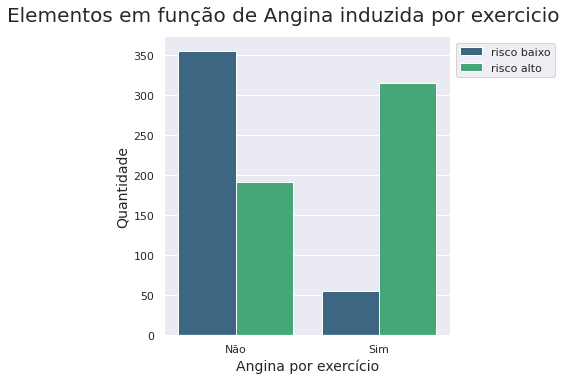

In [ ]:
# Catplot: Dor induzida por exercício (exercise angina)
catplot_categoricos("exercise angina", 
                    df, 
                    "Elementos em função de Angina induzida por exercicio", 
                    "Angina por exercício", 
                    ("Não", "Sim"))

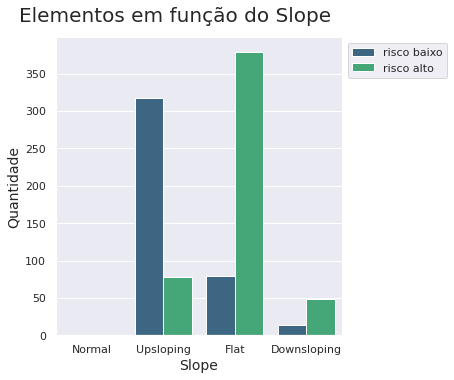

In [ ]:
# Catplot: ST slope
catplot_categoricos("ST slope", 
                    df, 
                    "Elementos em função do Slope", 
                    "Slope", 
                    ("Normal", "Upsloping", "Flat", "Downsloping"))

1.0    507
0.0    410
Name: target, dtype: int64


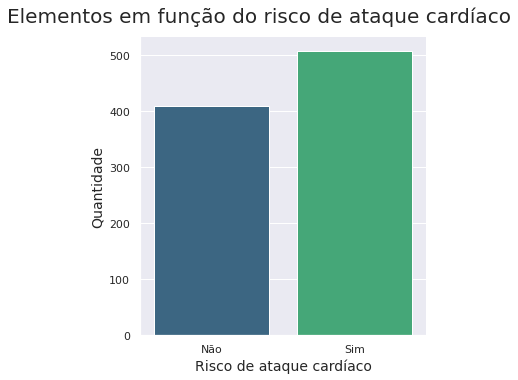

In [ ]:
# Catplot: Doenças cardiovasculares
print(df['target'].value_counts())

ax = sns.catplot(x="target", 
                 kind="count", 
                 palette="viridis", 
                 data=df)
ax.fig.suptitle("Elementos em função do risco de ataque cardíaco",
                fontsize=20, 
                y = 1.05)
ax.set_xlabels("Risco de ataque cardíaco", 
               fontsize=14)
ax.set_ylabels("Quantidade", 
               fontsize=14)
ax.set_xticklabels(labels=("Não", "Sim"))
ax

### Correlação entre variáveis independentes

In [ ]:
# coeficiente de correlação entre cardio e demais variáveis

df.corr().iloc[-1].round(3)

age                    0.282
sex                    0.305
chest pain type        0.472
resting bp s           0.118
cholesterol            0.094
fasting blood sugar    0.268
resting ecg            0.062
max heart rate        -0.401
exercise angina        0.495
oldpeak                0.404
ST slope               0.553
target                 1.000
Name: target, dtype: float64

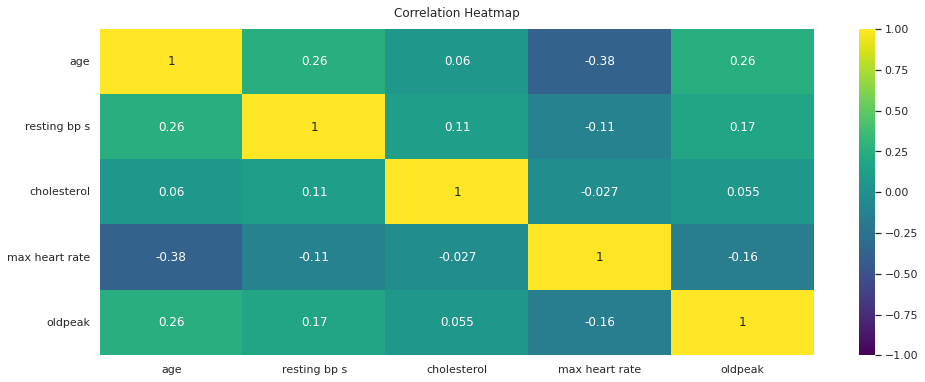

In [ ]:
#  matriz de correlação com mapa de calor
def matriz_correlacao(correlacao):
  plt.figure(figsize=(16, 6))
  heatmap = sns.heatmap(correlacao, 
                        vmin=-1, 
                        vmax=1,
                        annot=True, 
                        cmap='viridis')
  heatmap.set_title('Correlation Heatmap', 
                    fontdict={'fontsize':12}, 
                    pad=12);

matriz_correlacao(df[['age',
                     'resting bp s',
                     'cholesterol',
                     'max heart rate',
                     'oldpeak']].corr()
                  )


Conclusão: Uma vez que não possuem correlações fortes, não é necessária a remoção de variáveis independentes.

# Pré-processamento

Transformação de variáveis categóricas: one-hot encoding


In [ ]:
# criação da função de one-hot encoder
def one_hot_encoder(dataset, colunas_categoricas, drop_first=False):
    dataset = pd.get_dummies(dataset, 
                             columns=colunas_categoricas,
                             drop_first=drop_first)
    return dataset

# definição das variáveis que serão transformadas
variaveis_categoricas = [
  col for col in df.columns if 10 >= len(df[col].unique()) > 2]


In [ ]:
print(f'As variáveis categóricas %s serão transformadas com o one-hot encoder.' 
      % variaveis_categoricas)  

As variáveis categóricas ['chest pain type', 'resting ecg', 'ST slope'] serão transformadas com o one-hot encoder.


In [ ]:
# transformação das variáveis categóricas
df = one_hot_encoder(df, 
                     variaveis_categoricas, 
                     drop_first=False)
df

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,chest pain type_1.0,chest pain type_2.0,chest pain type_3.0,chest pain type_4.0,resting ecg_0.0,resting ecg_1.0,resting ecg_2.0,ST slope_0.0,ST slope_1.0,ST slope_2.0,ST slope_3.0
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,1,0,0
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,1.0,0,0,1,0,1,0,0,0,0,1,0
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,0,0,0,1,1,0,0,0,0,1,0
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1.0,1,0,0,0,1,0,0,0,0,1,0
913,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1.0,0,0,0,1,1,0,0,0,0,1,0
914,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,0,0,0,1,1,0,0,0,0,1,0
915,57.0,0.0,130.0,236.0,0.0,174.0,0.0,0.0,1.0,0,1,0,0,0,0,1,0,0,1,0


In [ ]:
one_hot_labels = {
    'chest pain type_1' : 'chest pain typical',
    'chest pain type_2' : 'chest pain angina',
    'chest pain type_3' : 'chest pain non-anginal',
    'chest pain type_4' : 'chest pain asymptomatic',
    'resting ecg_0' : 'resting ecg normal',
    'resting ecg_1' : 'resting ecg Abnormality',
    'resting ecg_2': 'resting ecg hypertrophy ',
    'ST slope_0': 'ST slope normal',
    'ST slope_1': 'ST slope upsloping',
    'ST slope_2': 'ST slope flat',
    'ST slope_3': 'ST slope downsloping',
}

df.rename(columns = one_hot_labels, inplace=True)

Divisão do dataset entre X e y (variáveis independentes e variável dependente) 

In [ ]:
# divisão do dataframe em variáveis independentes e dependente
def preprocessamento(df):
  df = df.copy()

  # Divisão entre X e y
  y = df['target'].copy()
  X = df.drop(columns=['target'], axis=1).copy()
  
  return X, y

In [ ]:
X, y = preprocessamento(df)

In [ ]:
# variáveis independentes
X

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,chest pain type_1.0,chest pain type_2.0,chest pain type_3.0,chest pain type_4.0,resting ecg_0.0,resting ecg_1.0,resting ecg_2.0,ST slope_0.0,ST slope_1.0,ST slope_2.0,ST slope_3.0
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,0,1,0,0,1,0,0,0,1,0,0
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,0,0,1,0,1,0,0,0,0,1,0
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,0,0,0,1,1,0,0,0,0,1,0
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1,0,0,0,1,0,0,0,0,1,0
913,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,0,0,0,1,1,0,0,0,0,1,0
914,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,0,0,0,1,1,0,0,0,0,1,0
915,57.0,0.0,130.0,236.0,0.0,174.0,0.0,0.0,0,1,0,0,0,0,1,0,0,1,0


In [ ]:
# variável dependente
y

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
912    1.0
913    1.0
914    1.0
915    1.0
916    0.0
Name: target, Length: 917, dtype: float64

In [ ]:
# divisão dos datasets entre treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [ ]:
# conferindo a distribuição dos dados da variável dependente (treino e teste)

print('Média em y =', y.mean())
print('Média em y_train =', y_train.mean())
print('Média em y_test =', y_test.mean())

print('\nA distribuição de casos positivos e negativos em y está equilibrada')

Média em y = 0.5528898582333697
Média em y_train = 0.5560407569141194
Média em y_test = 0.5434782608695652

A distribuição de casos positivos e negativos em y está equilibrada


# Modelos de classificação: Random Forest

Testando com Random Forest sem parâmetros definidos

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8739130434782608

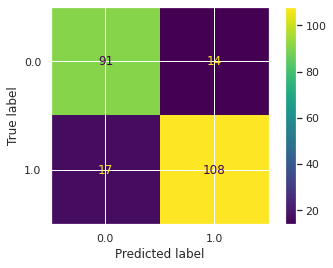

In [ ]:
# matrix de confusão do primeiro modelo de Random Forest
plot_confusion_matrix, plot_roc_curve
rf_model.fit(X_train, y_train)
plot_confusion_matrix(rf_model, 
                      X_test, 
                      y_test, 
                      values_format='d')

In [ ]:
# métricas de performance do primeiro modelo
y_pred_rf = rf_model.predict(X_test)
GS_report = classification_report(y_test, y_pred_rf)
print(GS_report)

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       105
         1.0       0.89      0.86      0.87       125

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



# Definindo Hiperparâmetros: GridSearchCV

In [ ]:
# definindo melhores hiperparâmetros para o segundo modelo de Random Forest

parameters = {'max_depth': [5,10,50,100],
              'min_samples_leaf': [2, 5, 30, 70, 100],
              'n_estimators': [5, 10, 50, 100],
}

clf = GridSearchCV(rf_model,
                   parameters,
                   return_train_score=True,
                   scoring = 'recall'
                   )

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
# segundo modelo de Random Forest
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# melhor score de acurácia do segundo modelo
clf.best_score_

0.9215652768284347

In [ ]:
# observando os resultados da validação cruzada
df_scores = pd.DataFrame()
df_scores['mean_train_score'] = clf.cv_results_['mean_train_score']
df_scores['mean_test_score'] = clf.cv_results_['mean_test_score']
df_scores.sort_values('mean_test_score', ascending=False)

,mean_train_score,mean_test_score
22,0.977743,0.921565
23,0.974478,0.921531
3,0.941099,0.918865
62,0.975129,0.916336
43,0.974471,0.913739
...,...,...
32,0.844249,0.856083
76,0.855371,0.856015
17,0.857332,0.853383
16,0.839610,0.835167


In [ ]:
# treinando o modelo RF com os melhores parâmetros
best_rf = clf.best_estimator_
best_rf.fit(X_train, y_train)
best_rf.score(X_test, y_test)

0.8695652173913043

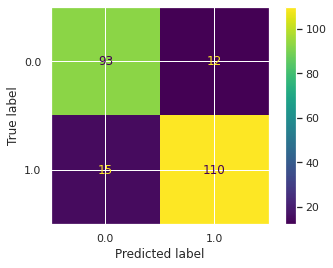

In [ ]:
# matrix de confusão do segundo modelo de Random Forest
plot_confusion_matrix, plot_roc_curve
best_rf.fit(X_train, y_train)
plot_confusion_matrix(best_rf, 
                      X_test, 
                      y_test, 
                      values_format='d')

In [ ]:
# métricas de performance do segundo modelo
y_pred_best_rf = best_rf.predict(X_test)
GS_report = classification_report(y_test, y_pred_best_rf)
print(GS_report)

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       105
         1.0       0.90      0.88      0.89       125

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



## Comparação de modelos:
* Acurácia no treino/teste
* Avaliação da sensibilidade (recall)

In [ ]:
# testando overfit no modelo sem hiperparâmetros

print('Acurácia no treino:', (rf_model.score(X_train, y_train)).round(3)) 
print('Acurácia no teste:', (rf_model.score(X_test, y_test)).round(3)) 
print('Sensibilidade (recall) no teste:', 
      (recall_score(y_test, y_pred_rf)).round(3))

Acurácia no treino: 1.0
Acurácia no teste: 0.865
Sensibilidade (recall) no teste: 0.864


In [ ]:
# testando overfit no modelo com hiperparâmetros

print('Acurácia no treino:', (best_rf.score(X_train, y_train)).round(3)) 
print('Acurácia no teste:', (best_rf.score(X_test, y_test)).round(3)) 
print('Sensibilidade (recall) no teste:', 
      (recall_score(y_test, y_pred_best_rf)).round(3))

Acurácia no treino: 0.951
Acurácia no teste: 0.883
Sensibilidade (recall) no teste: 0.88


# Relatório

Dois modelos de **Random Forest Classifier** foram aplicados aos dados visando prever a **classificação** dos registros entre pacientes com **baixo** ou **alto** risco de apresentar doenças cardíacas.

## Modelos
O **primeiro modelo** foi testado com as **definições padrões** do RandomForestClassifier.  

Enquanto o treinamento do **segundo modelo** contou com o processo de **ajuste de hiperparâmetros** mediante o GridSearchCV.

## Performance
As métricas escolhidas para a comparação dos modelos foram a **acurácia** e a **sensibilidade**.

A acurácia do **primeiro modelo** para o grupo de treino (100%) é um indicativo de problema de **overfitting**. 

O segundo modelo apresentou uma acurácia de previsão para o grupo de teste maior (88,3%), mesmo tendo uma acurácia menor para o grupo de treino (95,1%). 

Por fim, o risco de diagnósticos do tipo falso negativo em situações médicas eleva a importância da métrica de **sensibilidade** nesta comparação. Portanto, a taxa de **recall** de 88% (contra 86,4% do primeiro) faz do **segundo modelo** o melhor do presente projeto.